In [1]:
import pandas as pd
import folium
import os
import branca
import json
import requests
import math

from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import folium
from folium.plugins import TimestampedGeoJson

import copy

geo_counties_json = os.path.join('data','gz_2010_us_050_00_20m.json')
geo_counties_data = os.path.join('data','us-counties.csv')

In [2]:
with open(geo_counties_json,encoding = "ISO-8859-1") as file:
    data = json.load(file)

In [13]:
data['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]}}

In [4]:
df = pd.read_csv(geo_counties_data)
df = df.dropna()

In [6]:
# Bins for State total Cases 50
bin_edges = np.linspace(0,df.cases.max(),50)

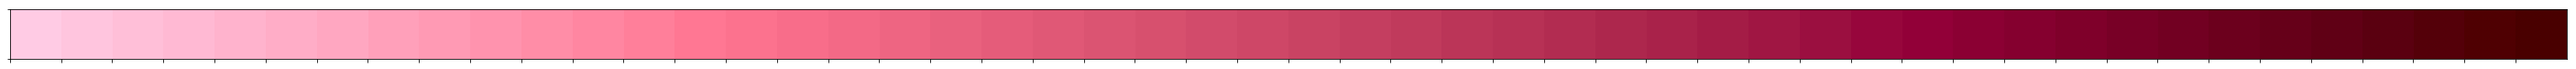

In [7]:
fifty_color_red = ['#490000', '#4f0002', '#540009', '#5a0010', '#600015', '#660019', '#6c001d', '#720022', '#780026', '#7f002a', '#85002f', '#8b0033', '#920038', '#97063c', '#9b0f40', '#a01643', '#a41c46', '#a9224a', '#ad274d', '#b22c51', '#b73155', '#bb3558', '#c03a5c', '#c43e60', '#c94363', '#ce4767', '#d24b6b', '#d7506e', '#db5472', '#e05876', '#e55c7a', '#e9617e', '#ee6582', '#f36986', '#f86d8a', '#fc728e', '#ff7793', '#ff7f9a', '#ff86a1', '#ff8da7', '#ff93ae', '#ff9ab4', '#ffa0ba', '#ffa7c1', '#ffadc7', '#ffb3cd', '#ffb9d3', '#ffbfd8', '#ffc5de', '#ffcbe4']
fifty_color_red.reverse()
color_scale = np.array(fifty_color_red)
sns.palplot(sns.color_palette(color_scale))

In [8]:
def color_coding(poll, bin_edges):    
    idx = np.digitize(poll, bin_edges, right=True)
    return color_scale[idx]


In [9]:
df['color'] = df['cases'].apply(lambda x: color_coding(x,bin_edges))

In [10]:
df.fips = df.fips.apply(lambda x: '0'+ str(int(x)) if len(str(x))<7 else str(int(x)))

In [11]:
df.head(10)

,date,county,state,fips,cases,deaths,color
0,2020-01-21,Snohomish,Washington,53061,1,0,#ffc5de
1,2020-01-22,Snohomish,Washington,53061,1,0,#ffc5de
2,2020-01-23,Snohomish,Washington,53061,1,0,#ffc5de
3,2020-01-24,Cook,Illinois,17031,1,0,#ffc5de
4,2020-01-24,Snohomish,Washington,53061,1,0,#ffc5de
5,2020-01-25,Orange,California,06059,1,0,#ffc5de
6,2020-01-25,Cook,Illinois,17031,1,0,#ffc5de
7,2020-01-25,Snohomish,Washington,53061,1,0,#ffc5de
8,2020-01-26,Maricopa,Arizona,04013,1,0,#ffc5de
9,2020-01-26,Los Angeles,California,06037,1,0,#ffc5de


In [14]:
info = data['features']
master = {}
for each in info:
    master[each['properties']['GEO_ID'][-5:]] = each
    

In [15]:
def create_geojson_features_modded(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {}
        feature = master[row.fips]
        feature['properties']['time'] = row.date
        feature['properties']['cases'] = row.cases
        feature['properties']['style'] = {'fillColor':row['color'],'fillOpacity': 0.25,'weight':0.5}
        test = copy.deepcopy(feature)
        features.append(test)
    print("COMPLETED")
    return features

In [16]:
a = create_geojson_features_modded(df)

> Creating GeoJSON features...
COMPLETED


In [18]:
def make_map(features):
    print('> Making map...')
    start=[48, -102]
    USA_map = folium.Map(location=start, control_scale=True, zoom_start=5)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': a}
        , period='P1D'
        , duration='P1D'
        , add_last_point=False
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM-DD'
        , time_slider_drag_update=True
    ).add_to(USA_map)
    print('> Done.')
    return USA_map


In [19]:
my_map = make_map(a)

> Making map...
> Done.


In [20]:
my_map.save('COVID_COUNTIES_USA.html')